# Preprocessing of BacDrop data

In [1]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from scipy.sparse import csr_matrix
from scipy import stats

import sys
sys.path.append('../')
from utils.utils import calc_sparsity

In [3]:
path_nSBM = '../data/raw/mudata_nSBM_hierarchy_2.h5mu'
path_KEGG = '../data/raw/mudata_KEGG_hierarchy_2.h5mu'
path_phrog = '../data/raw/mudata_phrog_hierarchy_2.h5mu'

In [4]:
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

MuData object with n_obs × n_vars = 437964 × 32110
  3 modalities
    SC_genes:	437964 x 13536
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	437964 x 13090
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	437964 x 5484
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

In [5]:
data_gex = data_nSBM['SC_genes'].copy()
data_gex

AnnData object with n_obs × n_vars = 437964 × 13536
    obs: 'strains'
    var: 'strains', 'matchin_protein', 'protein'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

In [100]:
data_gex.obs.strains.value_counts()

GSM5456486_MGH66_Abx3_P1_align2    44170
GSM5456504_Efm_CDS                  2434
GSM5456503_Ec_CDS                   1166
GSM5456505_PsA_CDS                   112
Name: strains, dtype: int64

In [57]:
1 - calc_sparsity(data_gex.X.A)

0.999382658112405

Cells?

In [59]:
print(np.mean(np.sum(data_gex.X.A, axis=1)))
print(np.median(np.sum(data_gex.X.A, axis=1)))

25.537132
20.0


Genes?

In [60]:
print(np.mean(np.sum(data_gex.X.A, axis=0)))
print(np.median(np.sum(data_gex.X.A, axis=0)))

90.33459
2.0


In [5]:
sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=False, inplace=True)
data_gex

AnnData object with n_obs × n_vars = 437964 × 13536
    obs: 'strains', 'n_genes_by_counts', 'total_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

In [27]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data_gex.var.n_cells_by_counts, data_gex.var.total_counts)
r_squared_genes = r_value ** 2
r_squared_genes

0.9957678082987915

In [28]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data_gex.obs.n_genes_by_counts, data_gex.obs.total_counts)
r_squared_cells = r_value ** 2
r_squared_cells

0.8858083204186492

In [7]:
lim  = min(data_gex.var.n_cells_by_counts.max(), data_gex.var.total_counts.max())
line = [0, lim]

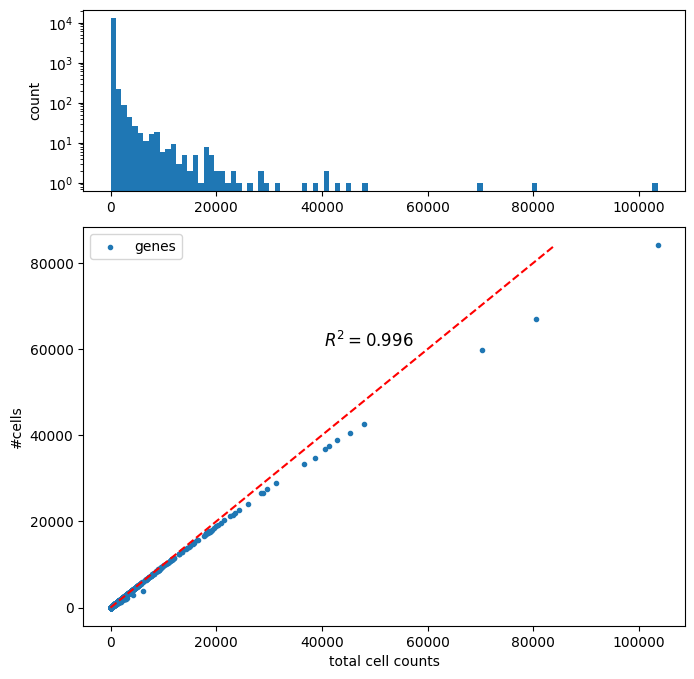

In [31]:
lim  = min(data_gex.var.n_cells_by_counts.max(), data_gex.var.total_counts.max())
line = [0, lim]

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)

ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2])

ax_main.scatter(data=data_gex.var, x="total_counts" , y="n_cells_by_counts", marker='.', label="genes")
ax_main.plot(line, line, color='red', linestyle="--")
ax_main.set(xlabel="total cell counts", ylabel="#cells")
ax_main.text(0.4, 0.7, f'$R^2 = {r_squared_genes:.3f}$', fontsize=12, transform=ax_main.transAxes)
ax_main.legend()

bins = np.arange(0, lim, 100)

ax_xDist.hist(data_gex.var["total_counts"], bins=100, align='mid')
ax_xDist.set(ylabel='count')
ax_xDist.set_yscale('log')
#ax_xDist.set_xlim(0, 10000)


plt.show()

In [66]:
data_gex

AnnData object with n_obs × n_vars = 437964 × 13536
    obs: 'strains', 'n_genes_by_counts', 'total_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

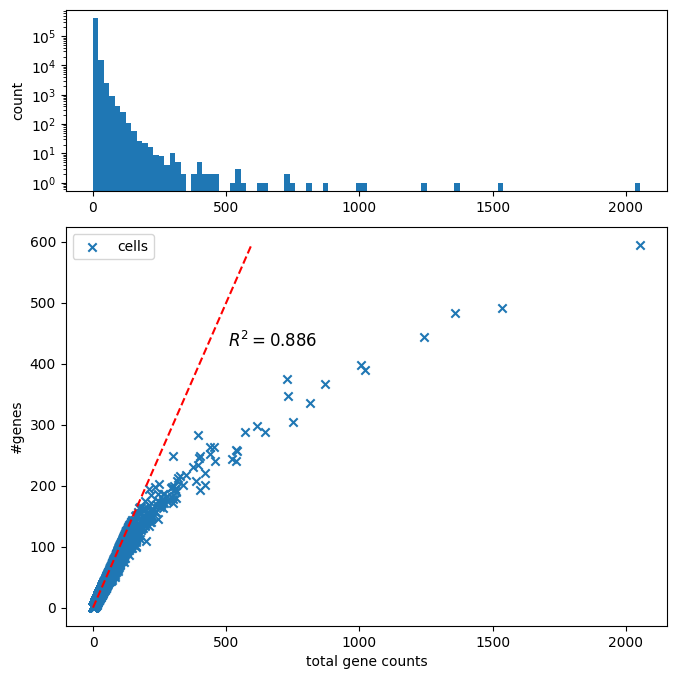

In [34]:
lim  = min(data_gex.obs.n_genes_by_counts.max(), data_gex.obs.total_counts.max())
line = [0, lim]

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)

ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2])

ax_main.scatter(data=data_gex.obs, x="total_counts" , y="n_genes_by_counts", marker='x', label="cells")
ax_main.plot(line, line, color='red', linestyle="--")
ax_main.set(xlabel="total gene counts", ylabel="#genes")
ax_main.text(0.27, 0.7, f'$R^2 = {r_squared_cells:.3f}$', fontsize=12, transform=ax_main.transAxes)
ax_main.legend()

bins = np.arange(0, lim, 100)

ax_xDist.hist(data_gex.obs["total_counts"], bins=100, align='mid')
ax_xDist.set(ylabel='count')
ax_xDist.set_yscale('log')
#ax_xDist.set_xlim(0, 10000)


plt.show()

### Removal of doublets and noise
Most of the cells express not more than ~250 genes per cell and are probably doublets, so they are removed. \
In a second step we remove all cells that have less than 15 counts, since they dont contain significant information and this was performed in the bacdrop paper as well. \

In [39]:
sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=False, inplace=True)

In [50]:
bins = np.arange(15, 255, 5)

In [41]:
bins = np.append(bins, 265)

In [42]:
bins = np.insert(bins, 0, 0)

Text(0.5, 1.0, 'Distribution of counts')

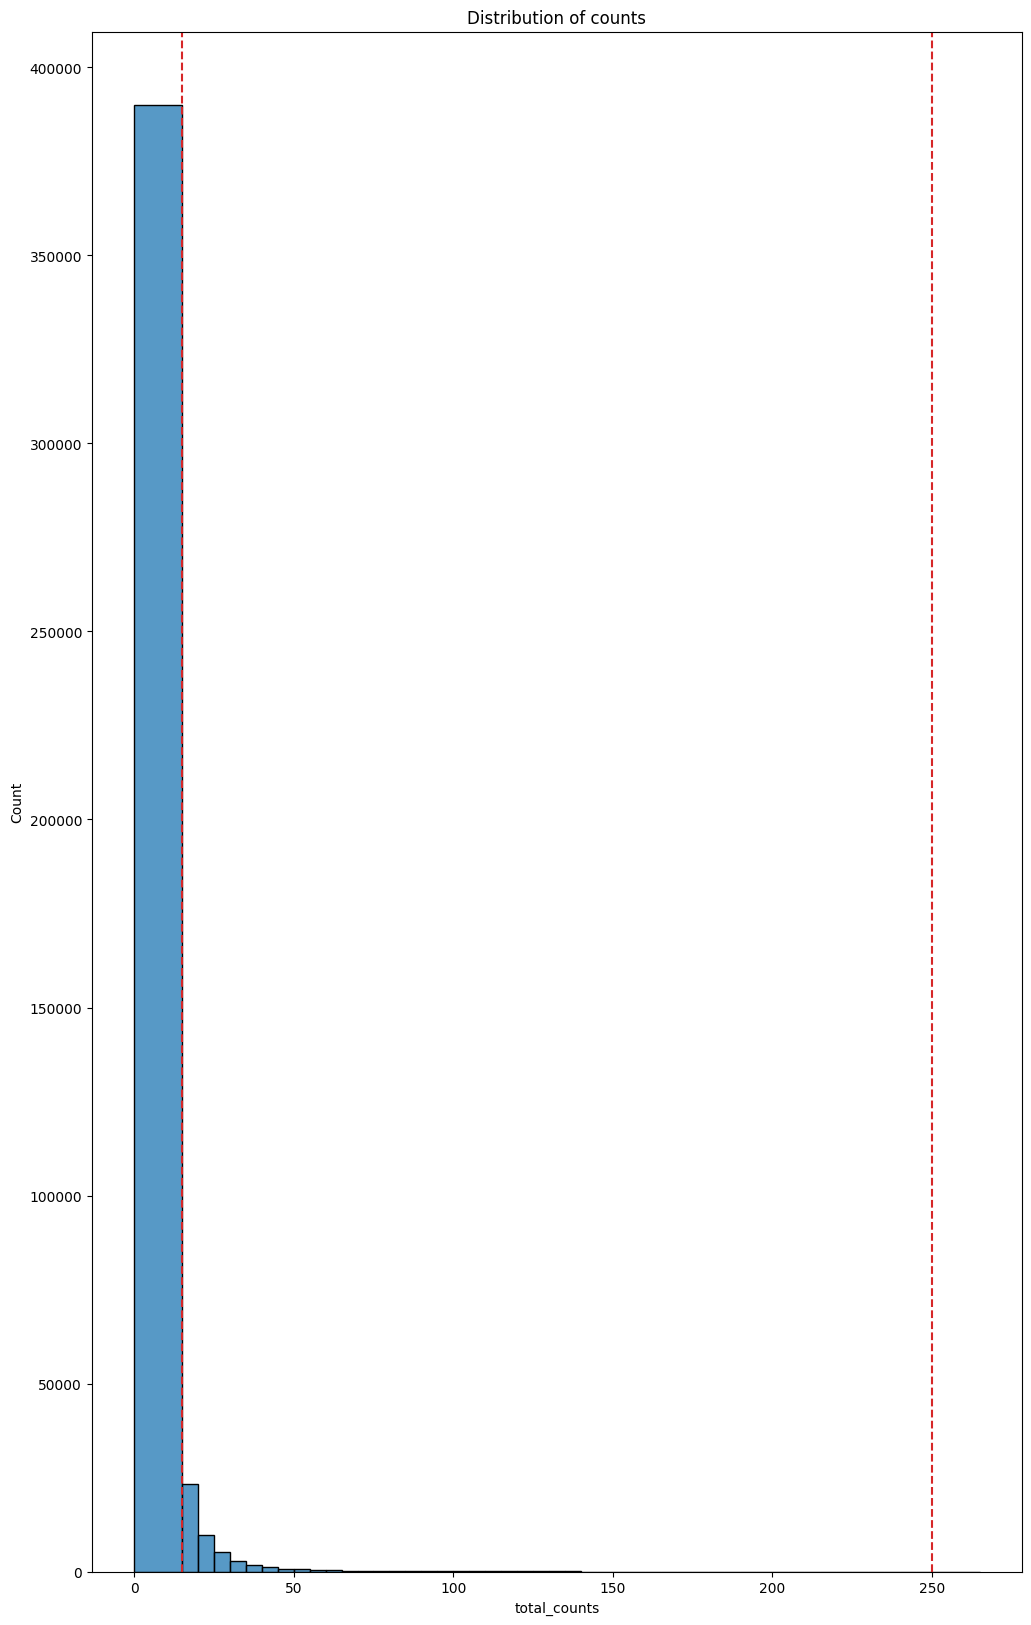

In [44]:
plt.figure(figsize=(12,12))
sns.histplot(data_gex.obs.total_counts, bins=bins)
#plt.yscale("log")
plt.axvline(x=15, color="C3", ls="--")
plt.axvline(x=250, color="C3", ls="--")
plt.title("Distribution of counts")

Text(0.5, 1.0, 'Distribution of counts')

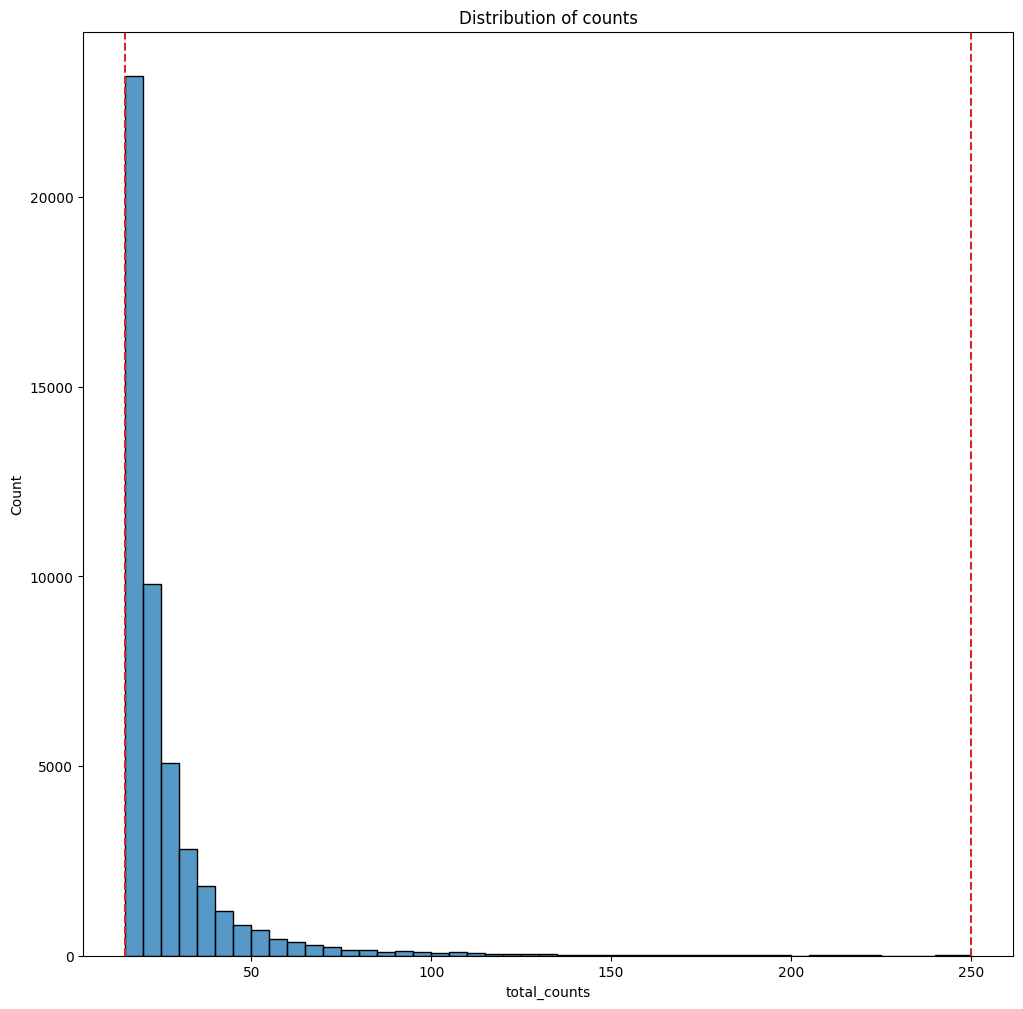

In [51]:
plt.figure(figsize=(12,12))
sns.histplot(data_gex.obs.total_counts, bins=bins)
#plt.yscale("log")
plt.axvline(x=15, color="C3", ls="--")
plt.axvline(x=250, color="C3", ls="--")
plt.title("Distribution of counts")

In [58]:
print('Original data shape:\t\t', data_gex.shape)
sc.pp.filter_cells(data_gex, max_counts=250)
print('Shape after doublet removal:\t', data_gex.shape)
sc.pp.filter_cells(data_gex, min_counts=15)
print('Shape after noise removal:\t', data_gex.shape)

Original data shape:		 (437964, 13536)
Shape after doublet removal:	 (437904, 13536)
Shape after noise removal:	 (47882, 13536)


In [54]:
1 - calc_sparsity(data_gex.X.A)

0.9981133914781443

         Falling back to preprocessing with `sc.pp.pca` and default params.


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


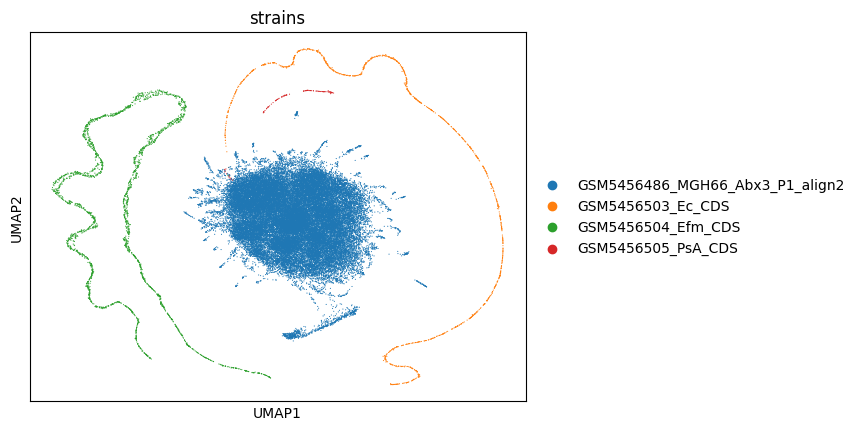

In [7]:
sc.pp.neighbors(data_gex, n_neighbors=15)
sc.tl.umap(data_gex)
sc.pl.umap(data_gex, color=["strains"])

### Split strain specific into 4 datasets

In [61]:
print('Original data shape (n x p):\t', data_gex.shape)
print('--------------------------------------------------')

data_gex_mgh = data_gex[data_gex.obs['strains'] == 'GSM5456486_MGH66_Abx3_P1_align2'].copy()
print('Original mgh data shape:\t', data_gex_mgh.shape)
sc.pp.filter_genes(data_gex_mgh, min_cells=1)
#sc.pp.calculate_qc_metrics(data_gex_mgh, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_mgh.shape)
print('--------------------------------------------------')


data_gex_efm = data_gex[data_gex.obs['strains'] == 'GSM5456504_Efm_CDS'].copy()
print('original efm data shape:\t', data_gex_efm.shape)
sc.pp.filter_genes(data_gex_efm, min_cells=1)
#sc.pp.calculate_qc_metrics(data_gex_efm, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_efm.shape)
print('--------------------------------------------------')


data_gex_ec = data_gex[data_gex.obs['strains'] == 'GSM5456503_Ec_CDS'].copy()
print('original ec data shape:\t\t', data_gex_ec.shape)
sc.pp.filter_genes(data_gex_ec, min_cells=1)
#sc.pp.calculate_qc_metrics(data_gex_ec, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_ec.shape)
print('--------------------------------------------------')


data_gex_psa = data_gex[data_gex.obs['strains'] == 'GSM5456505_PsA_CDS'].copy()
print('original psa data shape:\t', data_gex_psa.shape)
sc.pp.filter_genes(data_gex_psa, min_cells=1)
#sc.pp.calculate_qc_metrics(data_gex_psa, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_psa.shape)

Original data shape (n x p):	 (47882, 13536)
--------------------------------------------------
Original mgh data shape:	 (44170, 13536)
Strain specific genes shape:	 (44170, 3727)
--------------------------------------------------
original efm data shape:	 (2434, 13536)
Strain specific genes shape:	 (2434, 2048)
--------------------------------------------------
original ec data shape:		 (1166, 13536)
Strain specific genes shape:	 (1166, 2102)
--------------------------------------------------
original psa data shape:	 (112, 13536)
Strain specific genes shape:	 (112, 1601)


## Example of preprocessing on E. Coli
The other 3 strains can be found below

### Splitting into 3 datasets per strain
For each strain we now split into 3 different datasets based on different gene abundance levels:
1) All genes
2) High abundance genes (>=10 apperances)
3) Low abundance genes (<10 apperances)

In [62]:
filter, _ = sc.pp.filter_genes(data_gex_ec, min_cells=10, inplace=False)

In [63]:
ec_mudata = md.MuData({"all_genes": data_gex_ec.copy(), 
                       "high_abundance_genes": data_gex_ec[:, filter].copy(), 
                       "low_abundance_genes":  data_gex_ec[:, ~filter].copy()})

sc.pp.calculate_qc_metrics(ec_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(ec_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(ec_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


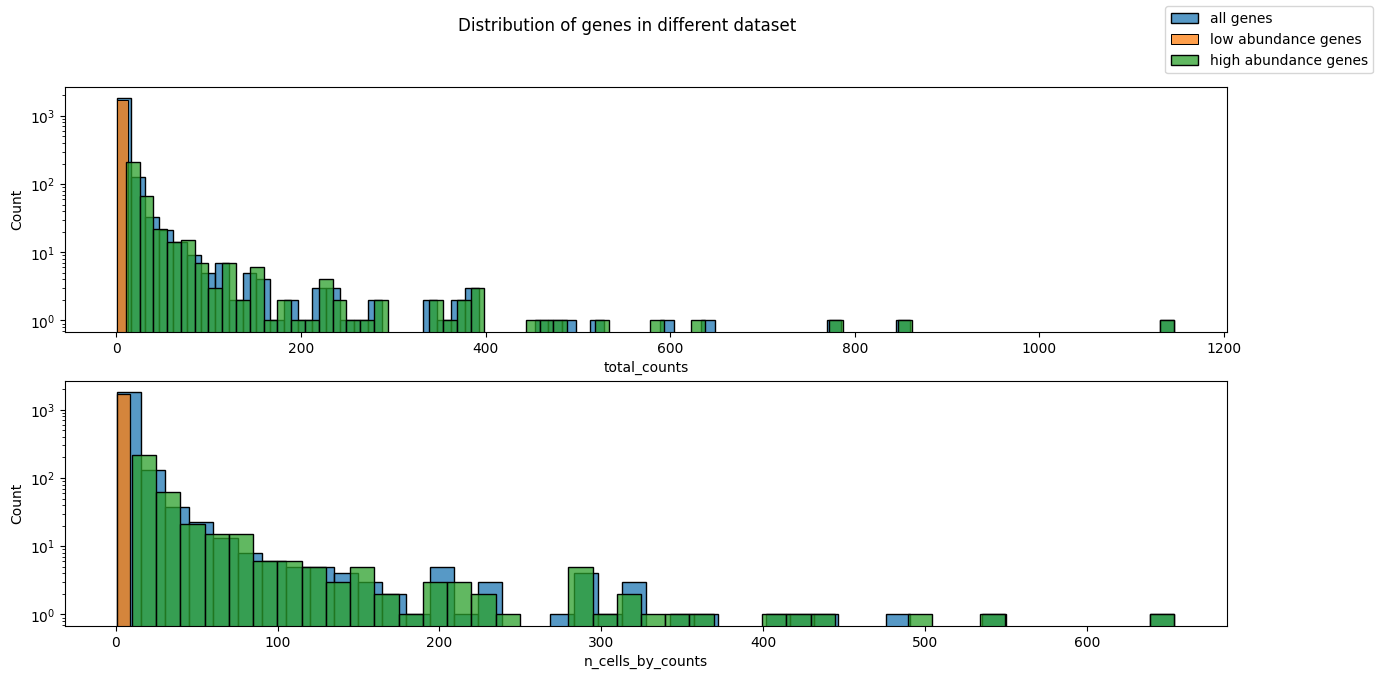

In [64]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(ec_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(ec_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(ec_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(ec_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(ec_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(ec_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

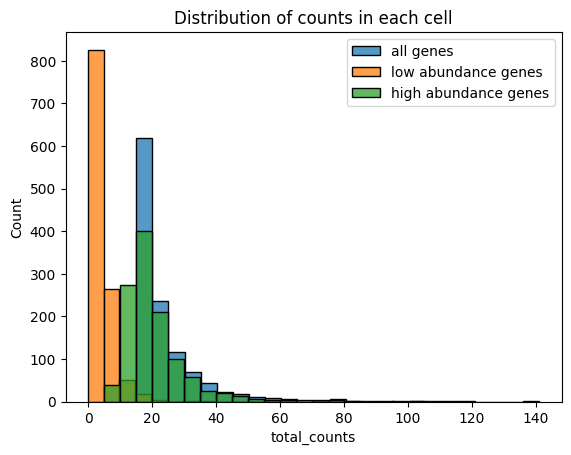

In [65]:
sns.histplot(ec_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
sns.histplot(ec_mudata["low_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C1", label="low abundance genes")
sns.histplot(ec_mudata["high_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C2", label="high abundance genes")
plt.title("Distribution of counts in each cell")
plt.legend()

In [66]:
agx, agy = ec_mudata["all_genes"].obs["total_counts"], ec_mudata["all_genes"].obs["n_genes_by_counts"] 
lagx, lagy = ec_mudata["low_abundance_genes"].obs["total_counts"], ec_mudata["low_abundance_genes"].obs["n_genes_by_counts"]
hagx, hagy =  ec_mudata["high_abundance_genes"].obs["total_counts"], ec_mudata["high_abundance_genes"].obs["n_genes_by_counts"]

_, _, r_value, _, _ = stats.linregress(agx, agy)
ag_r_squared = r_value ** 2

_, _, r_value, _, _ = stats.linregress(lagx, lagy)
lag_r_squared = r_value ** 2

_, _, r_value, _, _ = stats.linregress(hagx, hagy)
hag_r_squared = r_value ** 2

print(ag_r_squared, lag_r_squared, hag_r_squared)

0.956819539614272 0.9946645710405676 0.9416966967036964


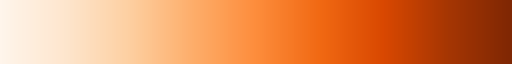

In [67]:
cmap = matplotlib.colormaps.get_cmap("Oranges")
cmap

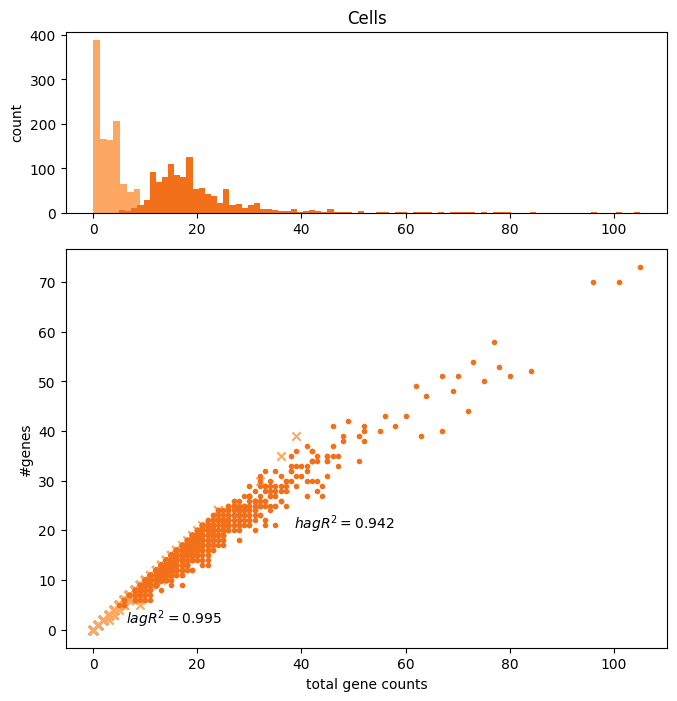

In [68]:
lim  = min(ec_mudata["all_genes"].obs["total_counts"].max(), ec_mudata["all_genes"].obs["n_genes_by_counts"].max())
line = [0, lim]

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)

ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2])

ax_main.scatter(data=ec_mudata["low_abundance_genes"].obs, x="total_counts" , y="n_genes_by_counts", marker='x', color=cmap(0.4))
ax_main.scatter(data=ec_mudata["high_abundance_genes"].obs, x="total_counts" , y="n_genes_by_counts", marker='.', color=cmap(0.6))

#ax_main.plot(line, line, color='red', label='x=y', linestyle="--")
ax_main.set(xlabel="total gene counts", ylabel="#genes")
ax_main.text(0.1, 0.06, f'$lag R^2 = {lag_r_squared:.3f}$', fontsize=10, transform=ax_main.transAxes)
ax_main.text(0.38, 0.3, f'$hag R^2 = {hag_r_squared:.3f}$', fontsize=10, transform=ax_main.transAxes)

bins = np.arange(0, lim, 100)

ax_xDist.hist(ec_mudata["low_abundance_genes"].obs["total_counts"], bins=30, align='mid', color=cmap(0.4))
ax_xDist.hist(ec_mudata["high_abundance_genes"].obs["total_counts"], bins=85, align='mid', color=cmap(0.6))
ax_xDist.set(ylabel='count')
#ax_xDist.set_yscale('log')
#ax_xDist.set_xlim(0, 10000)
plt.title("Cells")
plt.show()

In [69]:
agx, agy = ec_mudata["all_genes"].var["total_counts"], ec_mudata["all_genes"].var["n_cells_by_counts"] 
lagx, lagy = ec_mudata["low_abundance_genes"].var["total_counts"], ec_mudata["low_abundance_genes"].var["n_cells_by_counts"]
hagx, hagy =  ec_mudata["high_abundance_genes"].var["total_counts"], ec_mudata["high_abundance_genes"].var["n_cells_by_counts"]

_, _, r_value, _, _ = stats.linregress(agx, agy)
ag_r_squared = r_value ** 2

_, _, r_value, _, _ = stats.linregress(lagx, lagy)
lag_r_squared = r_value ** 2

_, _, r_value, _, _ = stats.linregress(hagx, hagy)
hag_r_squared = r_value ** 2

print(ag_r_squared, lag_r_squared, hag_r_squared)

0.9684709445528675 0.9874837923280326 0.9674563832271865


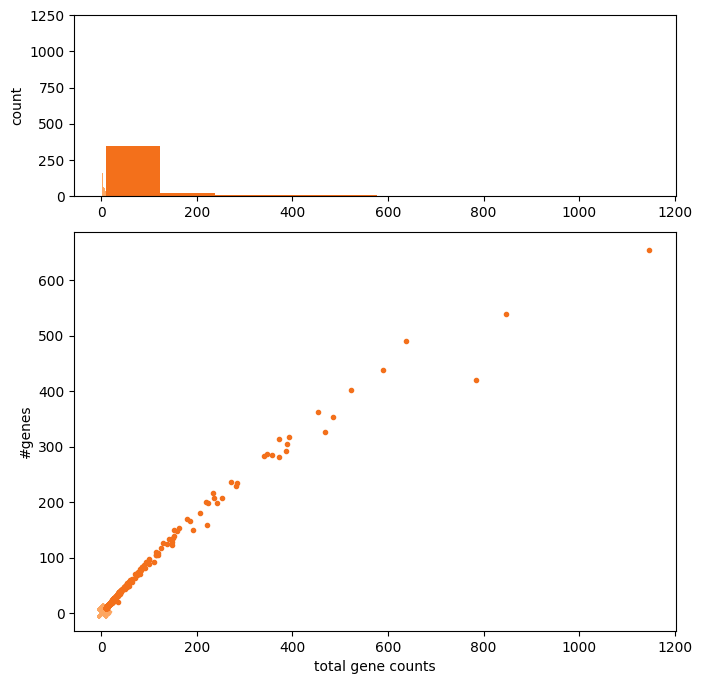

In [70]:
lim  = min(ec_mudata["all_genes"].var["total_counts"].max(), ec_mudata["all_genes"].var["n_cells_by_counts"].max())
line = [0, lim]

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)

ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2])

ax_main.scatter(data=ec_mudata["low_abundance_genes"].var, x="total_counts" , y="n_cells_by_counts", marker='x', color=cmap(0.4))

ax_main.scatter(data=ec_mudata["high_abundance_genes"].var, x="total_counts" , y="n_cells_by_counts", marker='.', color=cmap(0.6))

#ax_main.plot(line, line, color='red', label='x=y', linestyle="--")
ax_main.set(xlabel="total gene counts", ylabel="#genes")
#ax_main.text(0.27, 0.7, f'$R^2 = {r_squared:.3f}$', fontsize=12, transform=ax_main.transAxes)

bins = np.arange(0, lim, 100)

ax_xDist.hist(ec_mudata["low_abundance_genes"].var["total_counts"], align='mid', color=cmap(0.4))
ax_xDist.hist(ec_mudata["high_abundance_genes"].var["total_counts"], align='mid', color=cmap(0.6))
ax_xDist.set(ylabel='count')
#ax_xDist.set_yscale('log')
#ax_xDist.set_xlim(0, 10000)

plt.show()

### Normalization & Variance stabilization

Several normalization methods and VSTs are applied and saved in different layers:
- Log1p normalization
- Scanpy's total sum normalization with target sum being median count
- Square root transformation
- (Scran normalization (https://www.sc-best-practices.org/preprocessing_visualization/normalization.html & https://github.com/sfortma2/scranPY/blob/main/scranPY_tutorial.ipynb) --> Can be found in ./scran.ipynb notebook)

In [71]:
for i in ec_mudata.mod:
    ec_mudata[i].layers["raw_counts"]  = ec_mudata[i].X
    ec_mudata[i].layers["log1p"]       = sc.pp.log1p(ec_mudata[i], copy=True).X
    ec_mudata[i].layers["sqrt_counts"] = np.sqrt(ec_mudata[i].X)
    ec_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(ec_mudata[i], target_sum=None, inplace=False)['X']
ec_mudata

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 1166 × 4204
  3 modalities
    all_genes:	1166 x 2102
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	1166 x 387
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	1166 x 1715
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'E. Coli All Genes Normalization & VST')

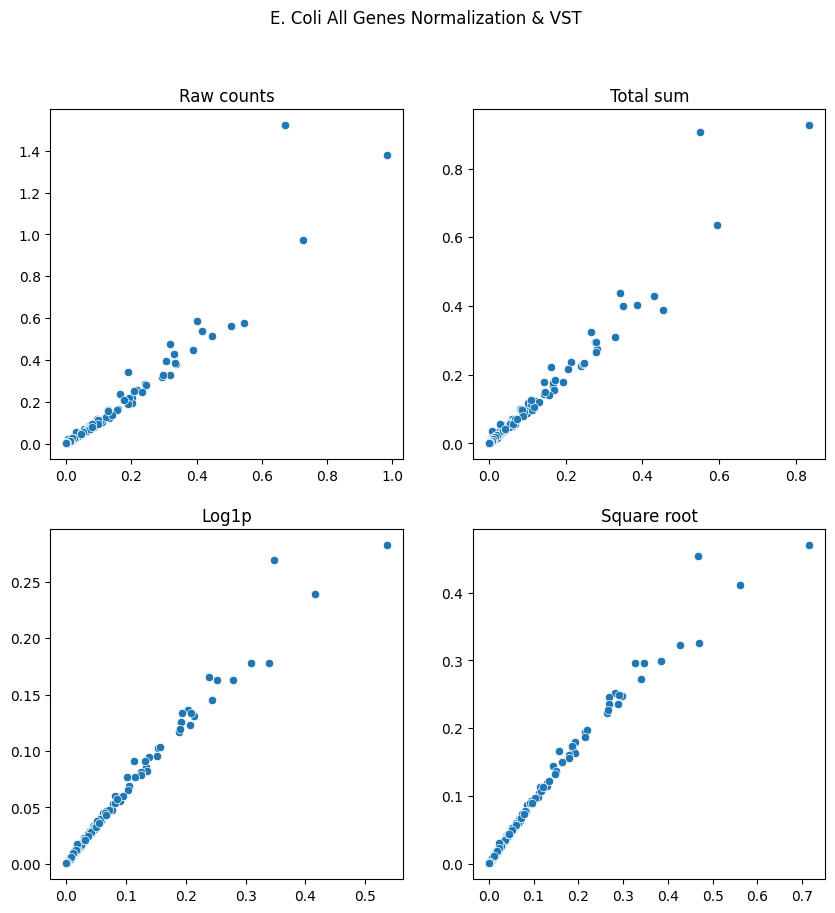

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("E. Coli All Genes Normalization & VST")

Text(0.5, 0.98, 'E. Coli Low And High Abundance Genes Normalization & VST')

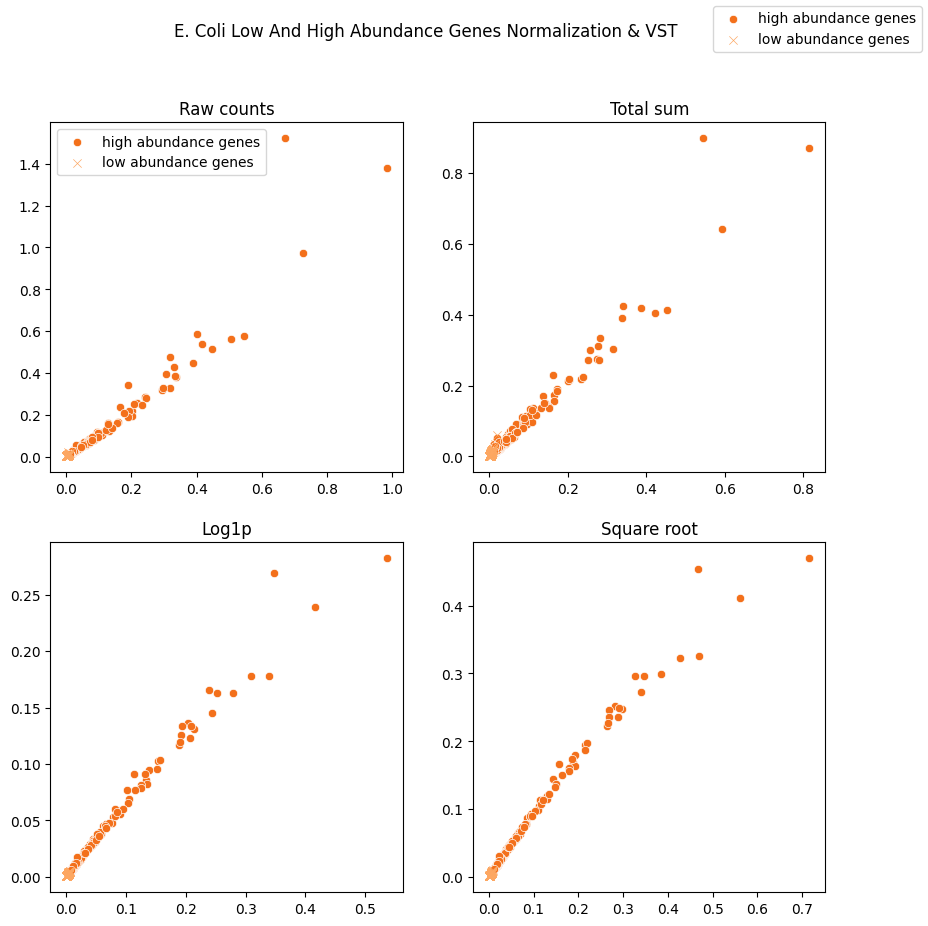

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].X.A, axis=0), 
                color=cmap(0.6), label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color=cmap(0.6), ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color=cmap(0.6), ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color=cmap(0.6), ax=axes[1][1])


sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                color=cmap(0.4), marker="x", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color=cmap(0.4), marker="x", ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color=cmap(0.4), marker="x", ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color=cmap(0.4), marker="x", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
#handles, labels = axes.get_legend_handles_labels()
fig.legend(loc='outside upper right')
fig.suptitle("E. Coli Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'E. Coli Low Abundance Genes Normalization & VST')

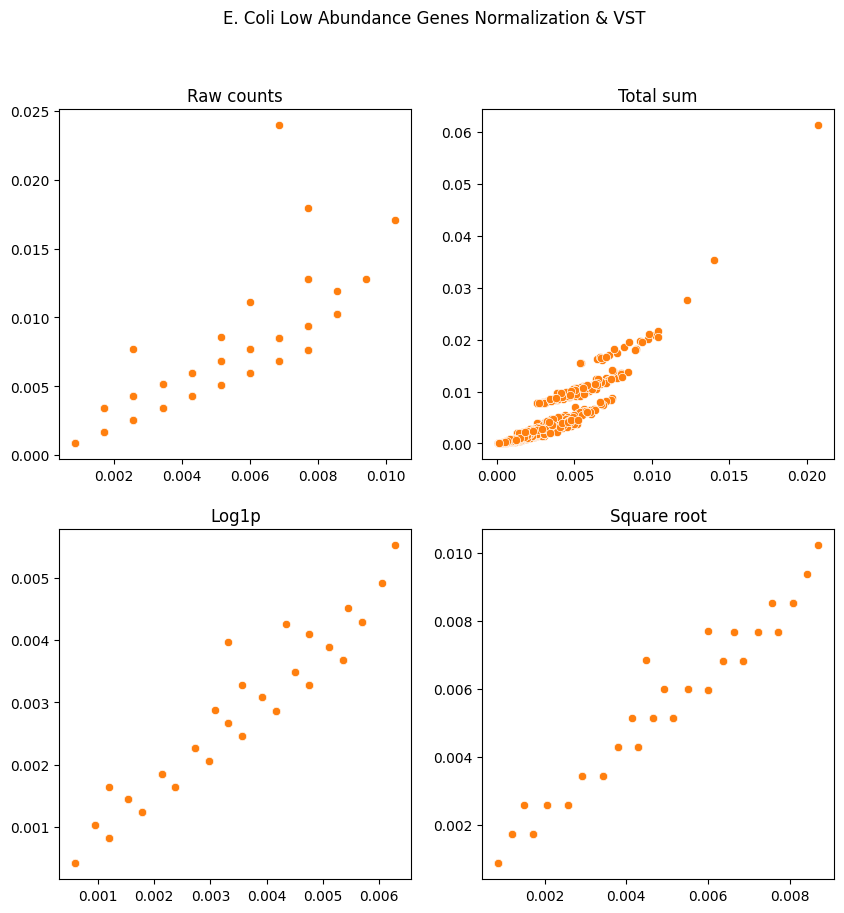

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("E. Coli Low Abundance Genes Normalization & VST")

In [75]:
print(1 - calc_sparsity(ec_mudata["all_genes"].X.A))
print(1 - calc_sparsity(ec_mudata["low_abundance_genes"].X.A))
print(1 - calc_sparsity(ec_mudata["high_abundance_genes"].X.A))

0.988651255930397
0.997908675844756
0.9476267723305898


## Efm

In [76]:
filter, _ = sc.pp.filter_genes(data_gex_efm, min_cells=10, inplace=False)

In [77]:
efm_mudata = md.MuData({"all_genes": data_gex_efm.copy(), 
                       "high_abundance_genes": data_gex_efm[:, filter].copy(), 
                       "low_abundance_genes":  data_gex_efm[:, ~filter].copy()})

sc.pp.calculate_qc_metrics(efm_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(efm_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(efm_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


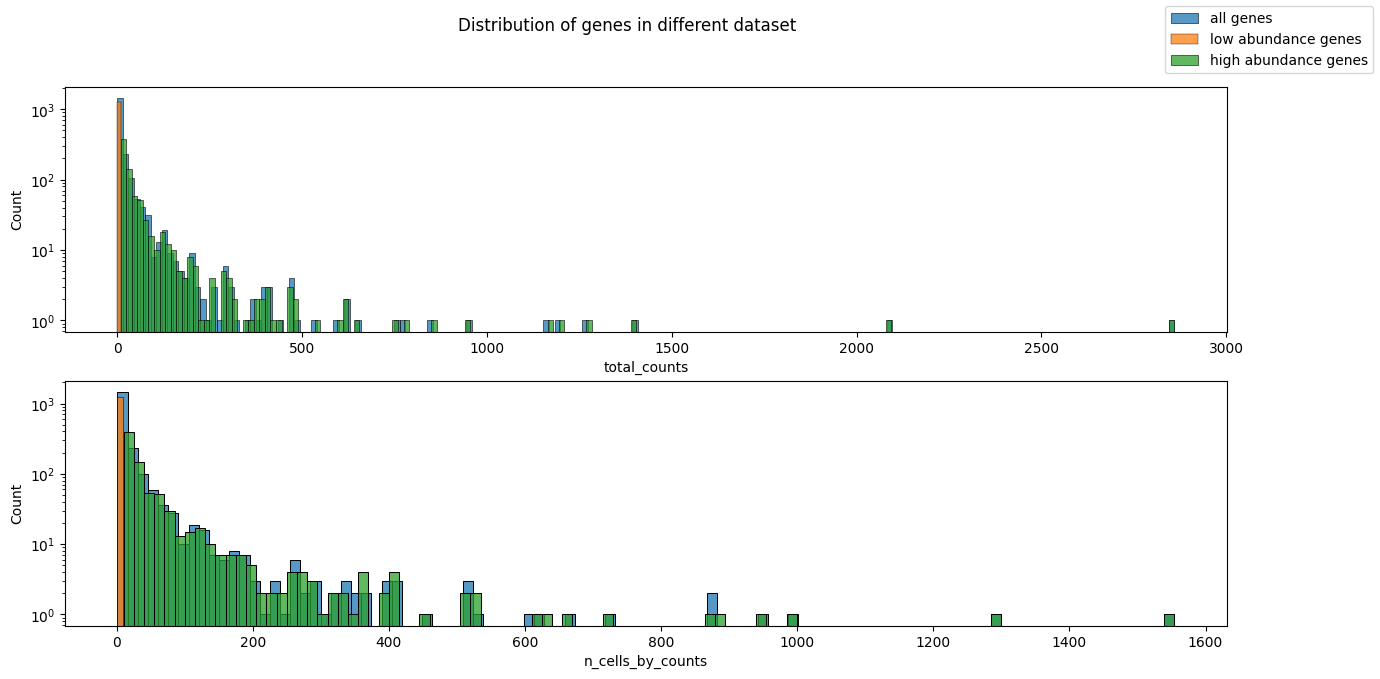

In [78]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(efm_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(efm_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(efm_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(efm_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(efm_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(efm_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

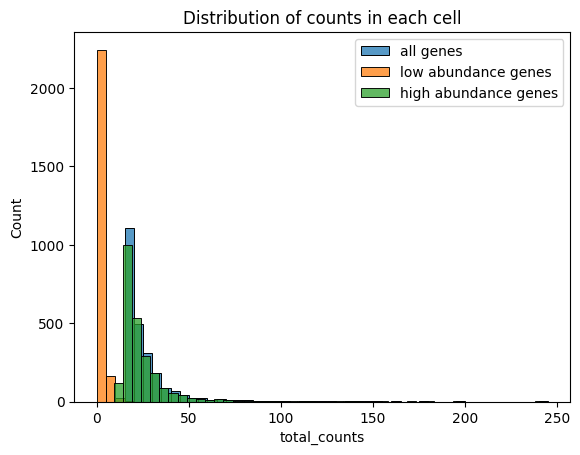

In [79]:
sns.histplot(efm_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
sns.histplot(efm_mudata["low_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C1", label="low abundance genes")
sns.histplot(efm_mudata["high_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C2", label="high abundance genes")
plt.title("Distribution of counts in each cell")
plt.legend()

In [80]:
for i in efm_mudata.mod:
    efm_mudata[i].layers["raw_counts"]  = efm_mudata[i].X
    efm_mudata[i].layers["log1p"]       = sc.pp.log1p(efm_mudata[i], copy=True).X
    efm_mudata[i].layers["sqrt_counts"] = np.sqrt(efm_mudata[i].X)
    efm_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(efm_mudata[i], target_sum=None, inplace=False)['X']
efm_mudata

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 2434 × 4096
  3 modalities
    all_genes:	2434 x 2048
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	2434 x 800
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	2434 x 1248
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'Efm All Genes Normalization & VST')

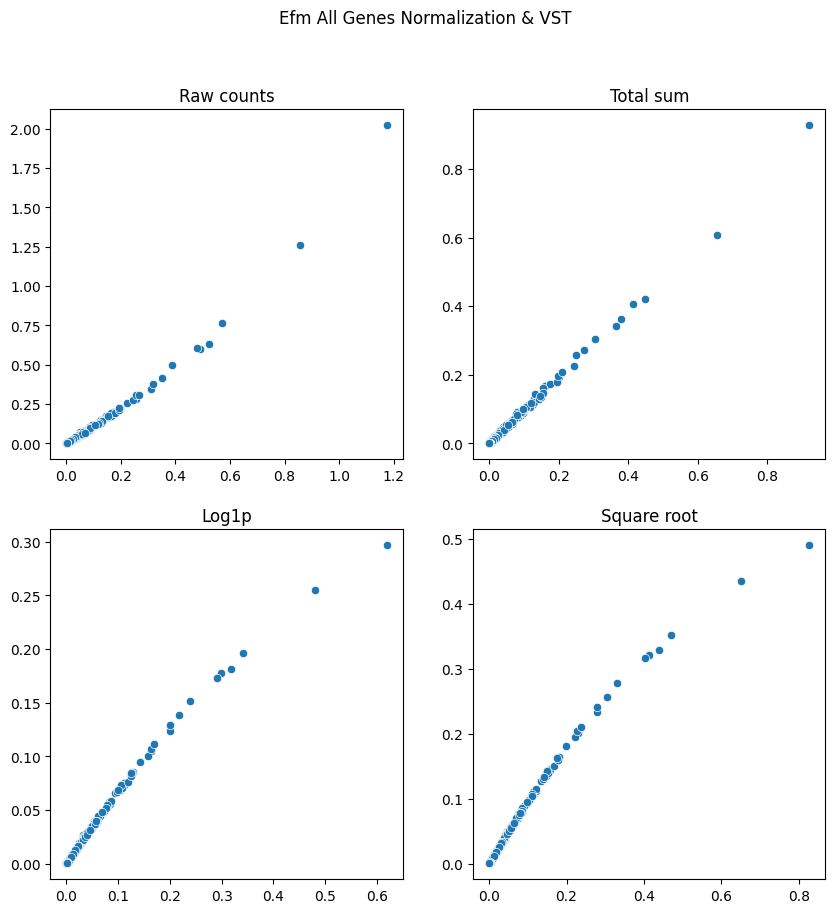

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Efm All Genes Normalization & VST")

Text(0.5, 0.98, 'Efm Low And High Abundance Genes Normalization & VST')

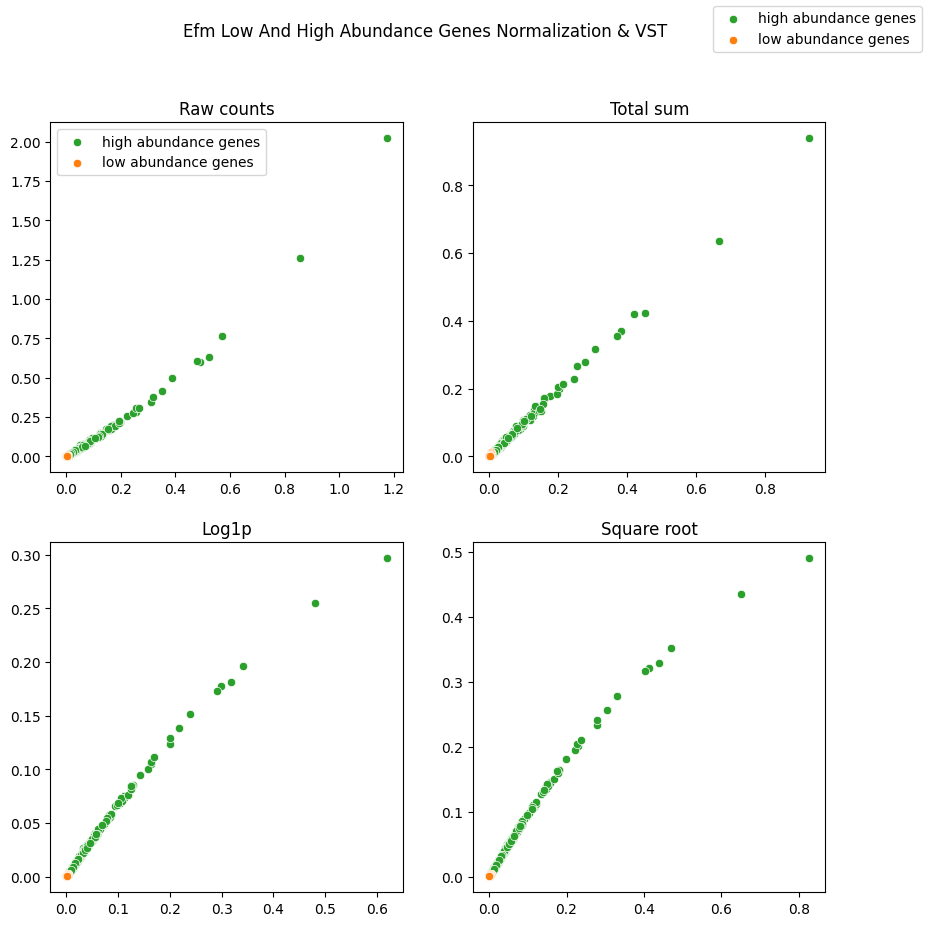

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("Efm Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'Efm Low Abundance Genes Normalization & VST')

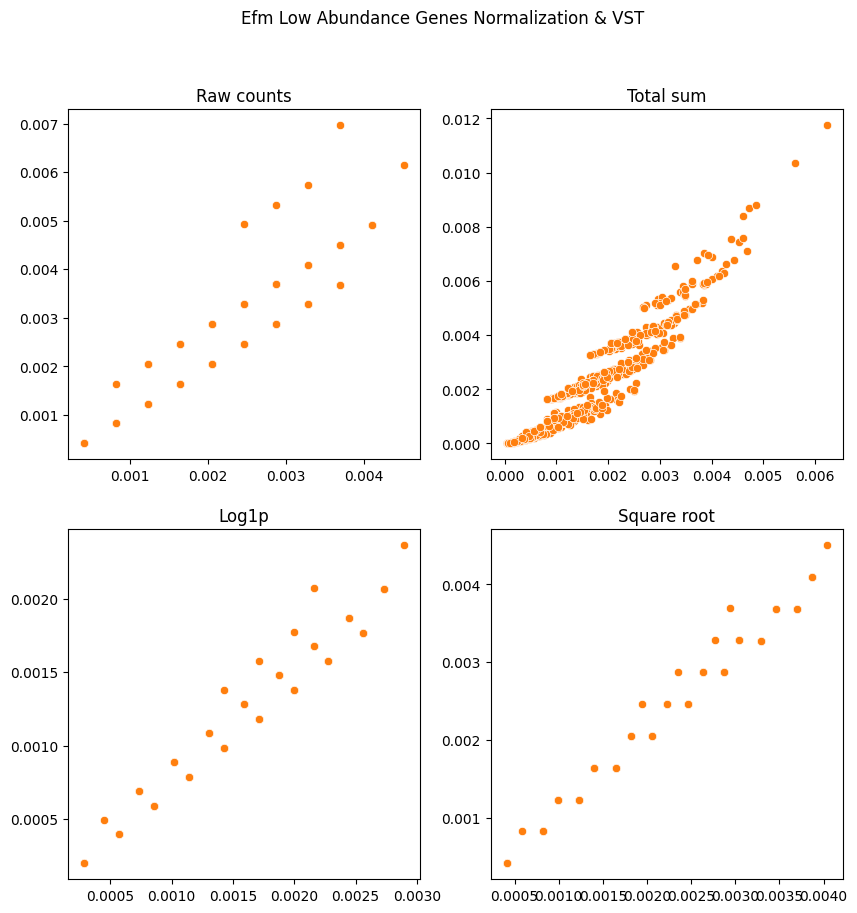

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Efm Low Abundance Genes Normalization & VST")

In [85]:
print(1 - calc_sparsity(efm_mudata["all_genes"].X.A))
print(1 - calc_sparsity(efm_mudata["low_abundance_genes"].X.A))
print(1 - calc_sparsity(efm_mudata["high_abundance_genes"].X.A))

0.9874573506188373
0.9986713334597476
0.9699635373870172


## Psa

In [86]:
filter, _ = sc.pp.filter_genes(data_gex_psa, min_cells=10, inplace=False)

In [87]:
psa_mudata = md.MuData({"all_genes": data_gex_psa.copy(), 
                       "high_abundance_genes": data_gex_psa[:, filter].copy(), 
                       "low_abundance_genes":  data_gex_psa[:, ~filter].copy()})

sc.pp.calculate_qc_metrics(psa_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(psa_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(psa_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


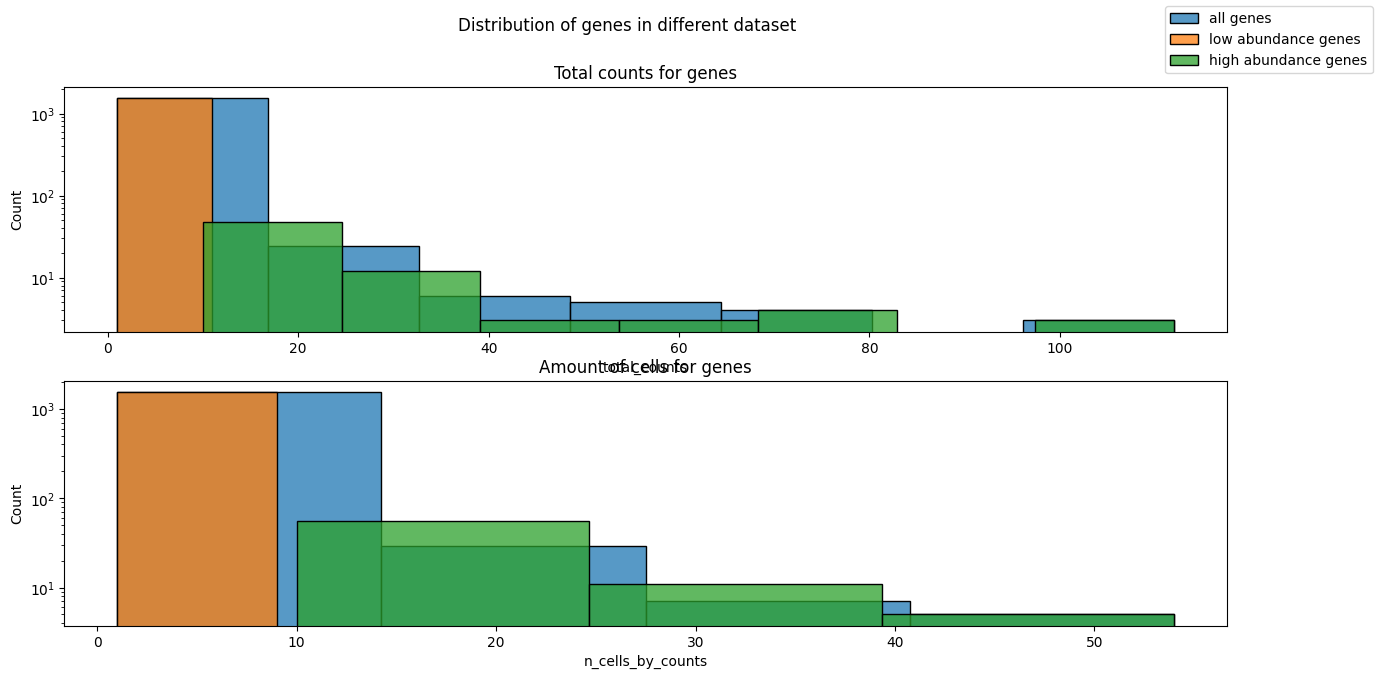

In [88]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(psa_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(psa_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(psa_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(psa_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(psa_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(psa_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

axes[0].set_title("Total counts for genes")
axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

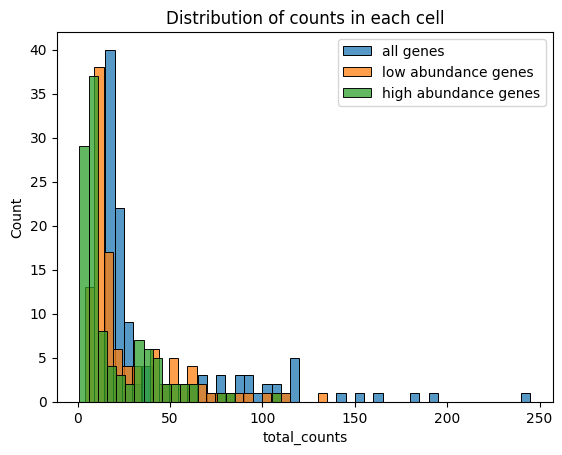

In [89]:
sns.histplot(psa_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
sns.histplot(psa_mudata["low_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C1", label="low abundance genes")
sns.histplot(psa_mudata["high_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C2", label="high abundance genes")
plt.title("Distribution of counts in each cell")
plt.legend()

In [90]:
for i in efm_mudata.mod:
    psa_mudata[i].layers["raw_counts"]  = psa_mudata[i].X
    psa_mudata[i].layers["log1p"]       = sc.pp.log1p(psa_mudata[i], copy=True).X
    psa_mudata[i].layers["sqrt_counts"] = np.sqrt(psa_mudata[i].X)
    psa_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(psa_mudata[i], target_sum=None, inplace=False)['X']
psa_mudata

MuData object with n_obs × n_vars = 112 × 3202
  3 modalities
    all_genes:	112 x 1601
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	112 x 72
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	112 x 1529
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'Psa All Genes Normalization & VST')

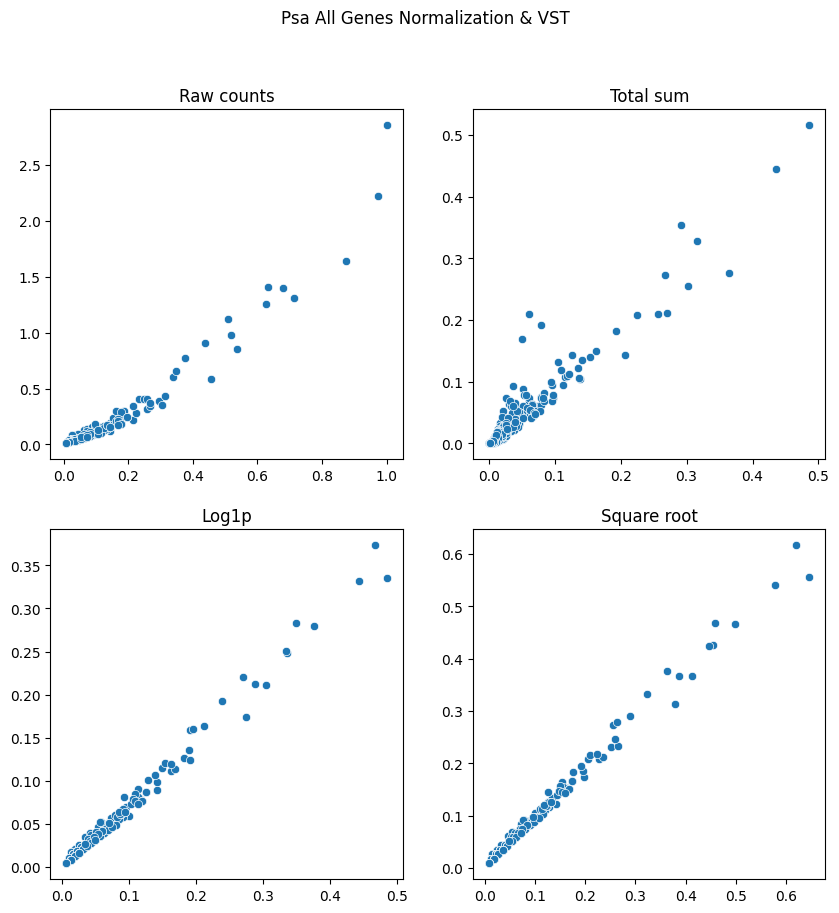

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Psa All Genes Normalization & VST")

Text(0.5, 0.98, 'Psa Low And High Abundance Genes Normalization & VST')

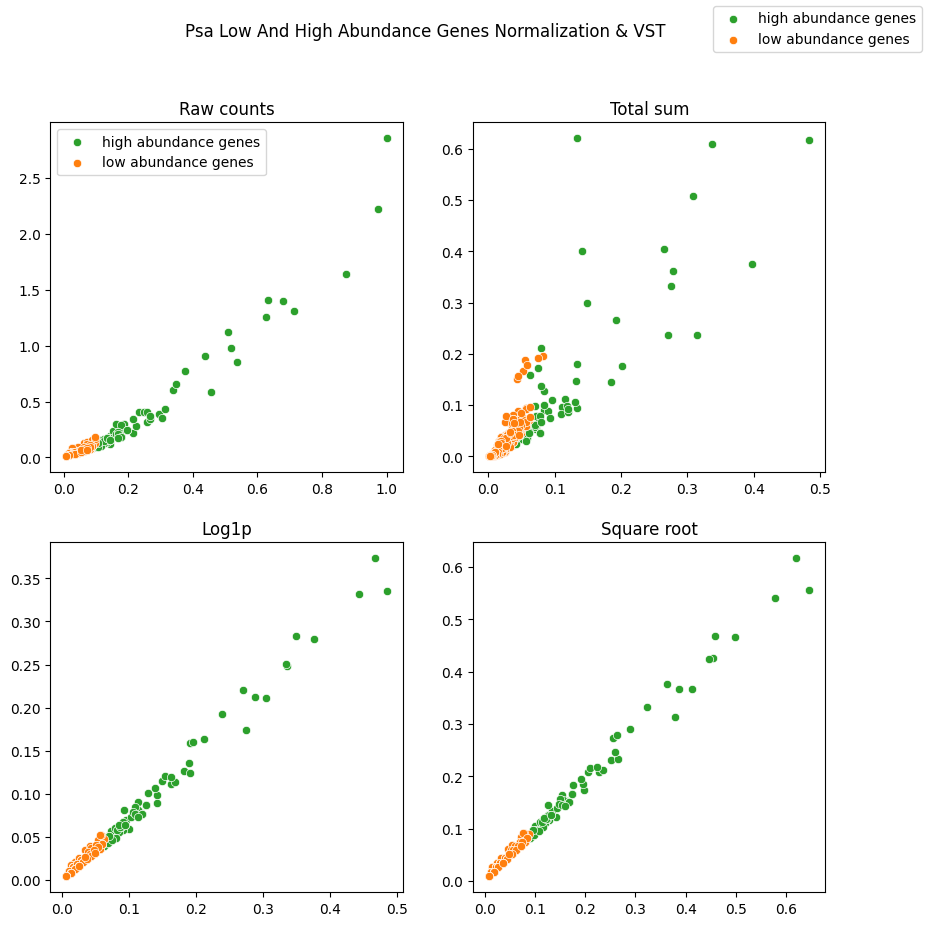

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("Psa Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'Psa Low Abundance Genes Normalization & VST')

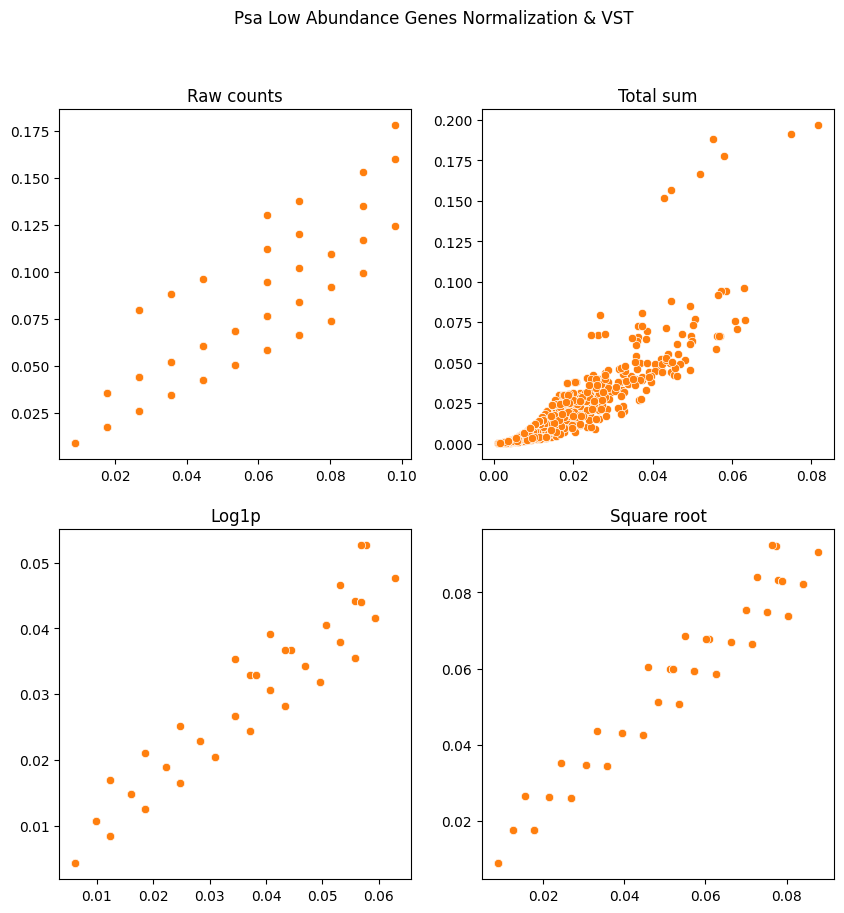

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Psa Low Abundance Genes Normalization & VST")

In [94]:
print(1 - calc_sparsity(psa_mudata["all_genes"].X.A))
print(1 - calc_sparsity(psa_mudata["low_abundance_genes"].X.A))
print(1 - calc_sparsity(psa_mudata["high_abundance_genes"].X.A))

0.9708496921566878
0.9814537980005605
0.7456597222222222


## Mgh

In [95]:
filter, _ = sc.pp.filter_genes(data_gex_mgh, min_cells=10, inplace=False)

In [96]:
mgh_mudata = md.MuData({"all_genes": data_gex_mgh.copy(), 
                       "high_abundance_genes": data_gex_mgh[:, filter].copy(), 
                       "low_abundance_genes":  data_gex_mgh[:, ~filter].copy()})

sc.pp.calculate_qc_metrics(mgh_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(mgh_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(mgh_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


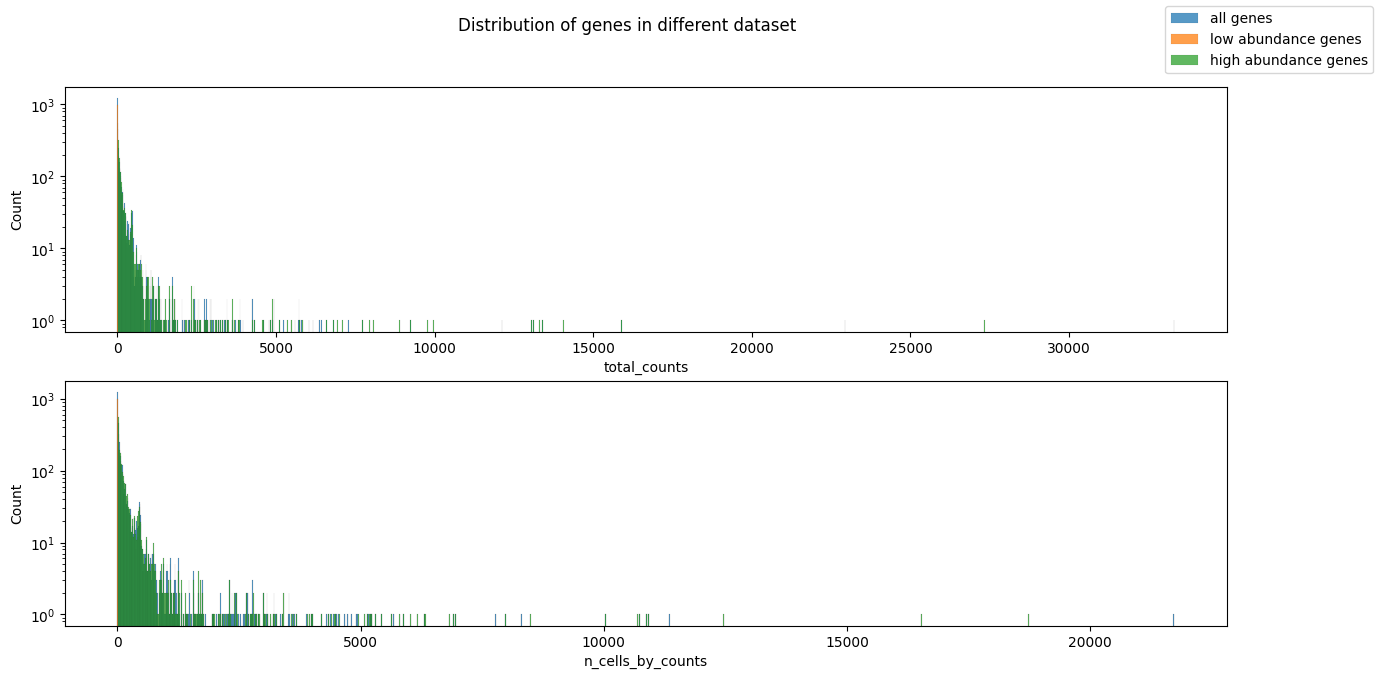

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(mgh_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(mgh_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(mgh_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(mgh_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(mgh_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(mgh_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

#axes[0].set_title("Total counts for genes")
#axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

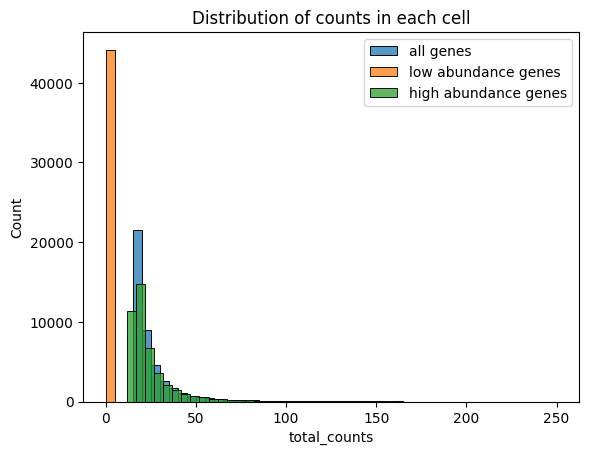

In [44]:
sns.histplot(mgh_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
sns.histplot(mgh_mudata["low_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C1", label="low abundance genes")
sns.histplot(mgh_mudata["high_abundance_genes"].obs["total_counts"], binwidth=5, kde=False, color="C2", label="high abundance genes")
plt.title("Distribution of counts in each cell")
plt.legend()

In [97]:
for i in efm_mudata.mod:
    mgh_mudata[i].layers["raw_counts"]  = mgh_mudata[i].X
    mgh_mudata[i].layers["log1p"]       = sc.pp.log1p(mgh_mudata[i], copy=True).X
    mgh_mudata[i].layers["sqrt_counts"] = np.sqrt(mgh_mudata[i].X)
    mgh_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(mgh_mudata[i], target_sum=None, inplace=False)['X']
mgh_mudata

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 44170 × 7454
  3 modalities
    all_genes:	44170 x 3727
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	44170 x 2733
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	44170 x 994
      obs:	'strains', 'n_counts', 'n_genes_by_counts', 'total_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'Mgh All Genes Normalization & VST')

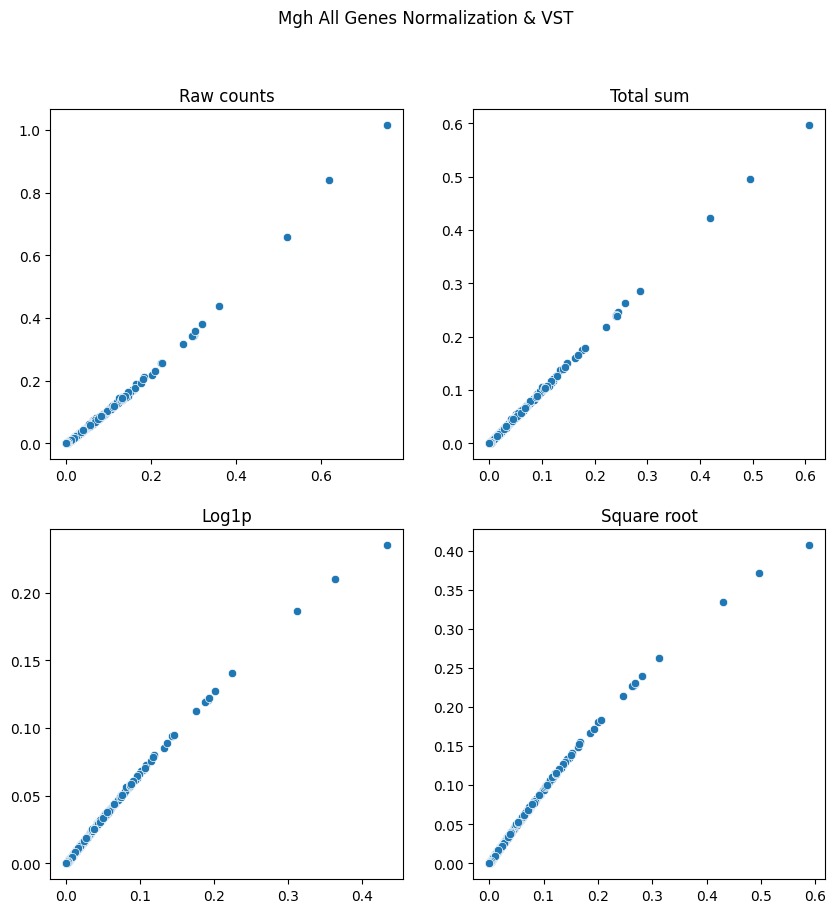

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Mgh All Genes Normalization & VST")

Text(0.5, 0.98, 'Mgh Low And High Abundance Genes Normalization & VST')

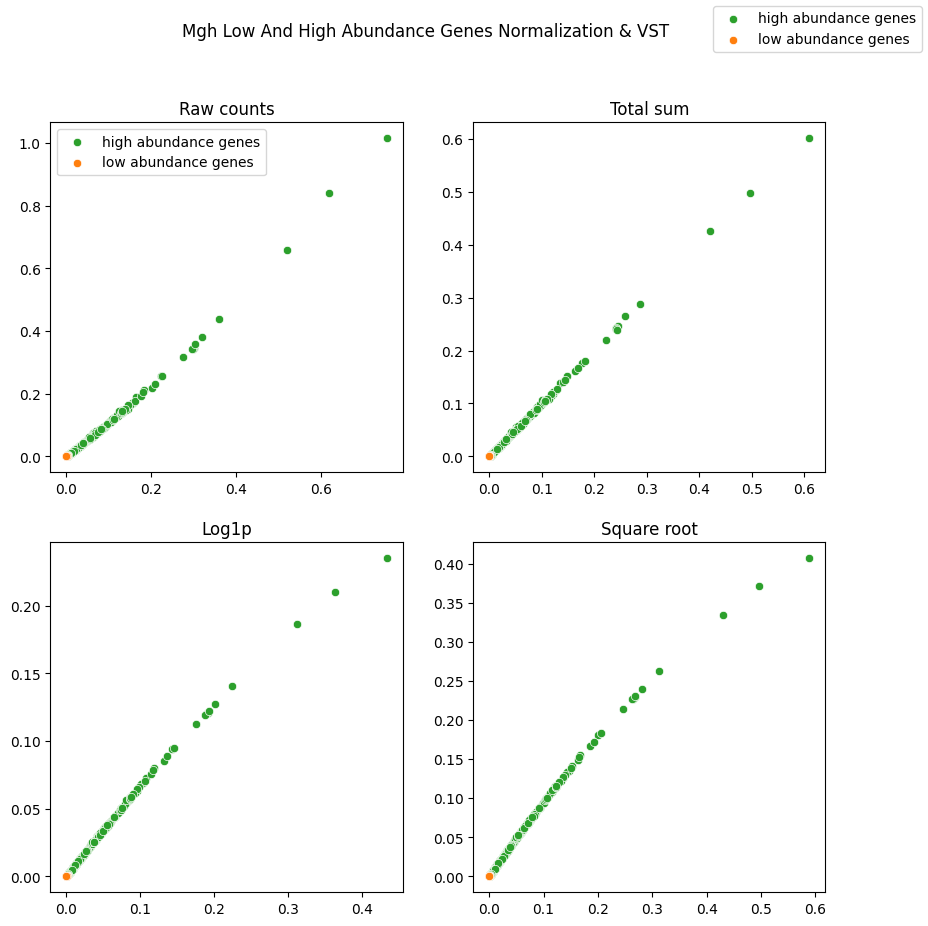

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("Mgh Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'Mgh Low Abundance Genes Normalization & VST')

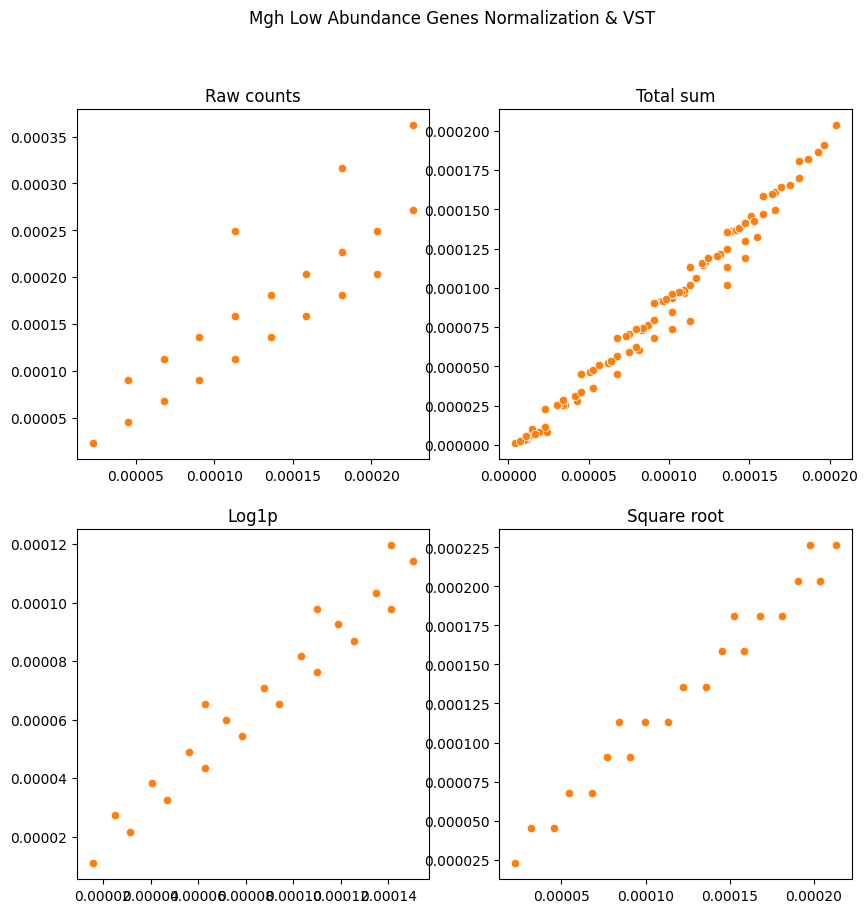

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Mgh Low Abundance Genes Normalization & VST")

In [98]:
print(1 - calc_sparsity(mgh_mudata["all_genes"].X.A))
print(1 - calc_sparsity(mgh_mudata["low_abundance_genes"].X.A))
print(1 - calc_sparsity(mgh_mudata["high_abundance_genes"].X.A))

0.9931527571808777
0.9999142010769622
0.9906936004912663


In [51]:
ec_mudata.write("../data/preprocessed/ec_mudata_prepro.h5mu")
efm_mudata.write("../data/preprocessed/efm_mudata_prepro.h5mu")
psa_mudata.write("../data/preprocessed/psa_mudata_prepro.h5mu")
mgh_mudata.write("../data/preprocessed/mgh_mudata_prepro.h5mu")

#sc.write(filename='../data/preprocessed/mgh_prepro.h5ad', adata=data_gex_mgh)
#sc.write(filename='../data/preprocessed/efm_prepro.h5ad', adata=data_gex_efm)
#sc.write(filename='../data/preprocessed/ec_prepro.h5ad', adata=data_gex_ec)
#sc.write(filename='../data/preprocessed/psa_prepro.h5ad', adata=data_gex_psa)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
